In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from copy import deepcopy

from utils.preprocessing import extract_vocab, encode

In [88]:
dsc_df = pd.read_csv('data/data_dsc.csv')
fp_df = pd.read_csv('data/data_fp.csv')
full_df = pd.concat([dsc_df, fp_df.drop(columns=['Title', 'IC50', 'SMILES'])], axis=1).drop(columns=['Unnamed: 0'])

In [89]:
strcutures = full_df['SMILES'].tolist() + full_df['Title'].tolist()
target = full_df['IC50'].tolist()

vocab, token2id, id2token = extract_vocab(strcutures)

<Axes: ylabel='Count'>

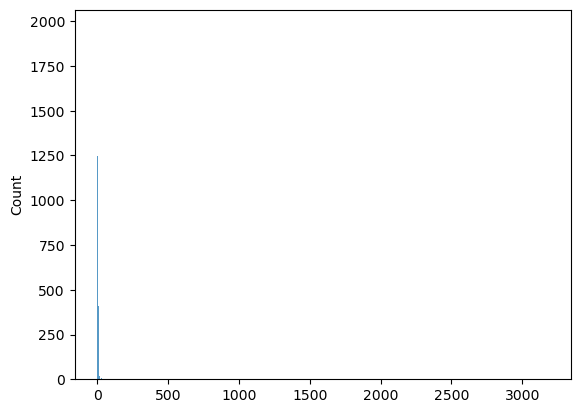

In [90]:
sns.histplot(target)

In [91]:
def pad_list(lst, max_length):
    return lst + [0] * (max_length - len(lst))

full_df['Title'] = full_df['Title'].apply(lambda x: list(encode(x, vocab, token2id)))
full_df['SMILES'] = full_df['SMILES'].apply(lambda x: list(encode(x, vocab, token2id)))

max_title_length = max(full_df['Title'].apply(len))
max_smiles_length = max(full_df['SMILES'].apply(len))
full_df['Title'] = full_df['Title'].apply(lambda x: pad_list(x, max_title_length))
full_df['SMILES'] = full_df['SMILES'].apply(lambda x: pad_list(x, max_smiles_length))

## Boostings

In [92]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns=['IC50']), full_df['IC50'], test_size=0.2, random_state=42)

In [93]:
model = CatBoostRegressor(iterations=5000,
                          eval_metric='R2',
                          loss_function='MAE',
                          verbose=False,
                          depth=2)

In [94]:
model.fit(X_train,
    y_train,
    embedding_features=['Title', 'SMILES'],
    use_best_model=True,
    eval_set=(X_test, y_test),
 )

In [95]:
y_preds = model.predict(X_test)

In [96]:
print(r2_score(y_test, y_preds))

0.023394720867005225


## Boosting without emb features to understand feature importance

In [112]:
full_df['random'] = np.random.rand(full_df.shape[0], 1)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns=['IC50', 'Title', 'SMILES']), full_df['IC50'], test_size=0.2, random_state=42)

In [115]:
model = CatBoostRegressor(iterations=5000,
                          eval_metric='R2',
                          loss_function='MAE',
                          verbose=False,
                          depth=2)

In [116]:
model.fit(X_train,
    y_train,
    # embedding_features=['Title', 'SMILES'],
    use_best_model=True,
    eval_set=(X_test, y_test),
 )

In [117]:
y_preds = model.predict(X_test)

In [118]:
print(r2_score(y_test, y_preds))

0.00874064246138373


Text(0.5, 1.0, 'Feature Importance')

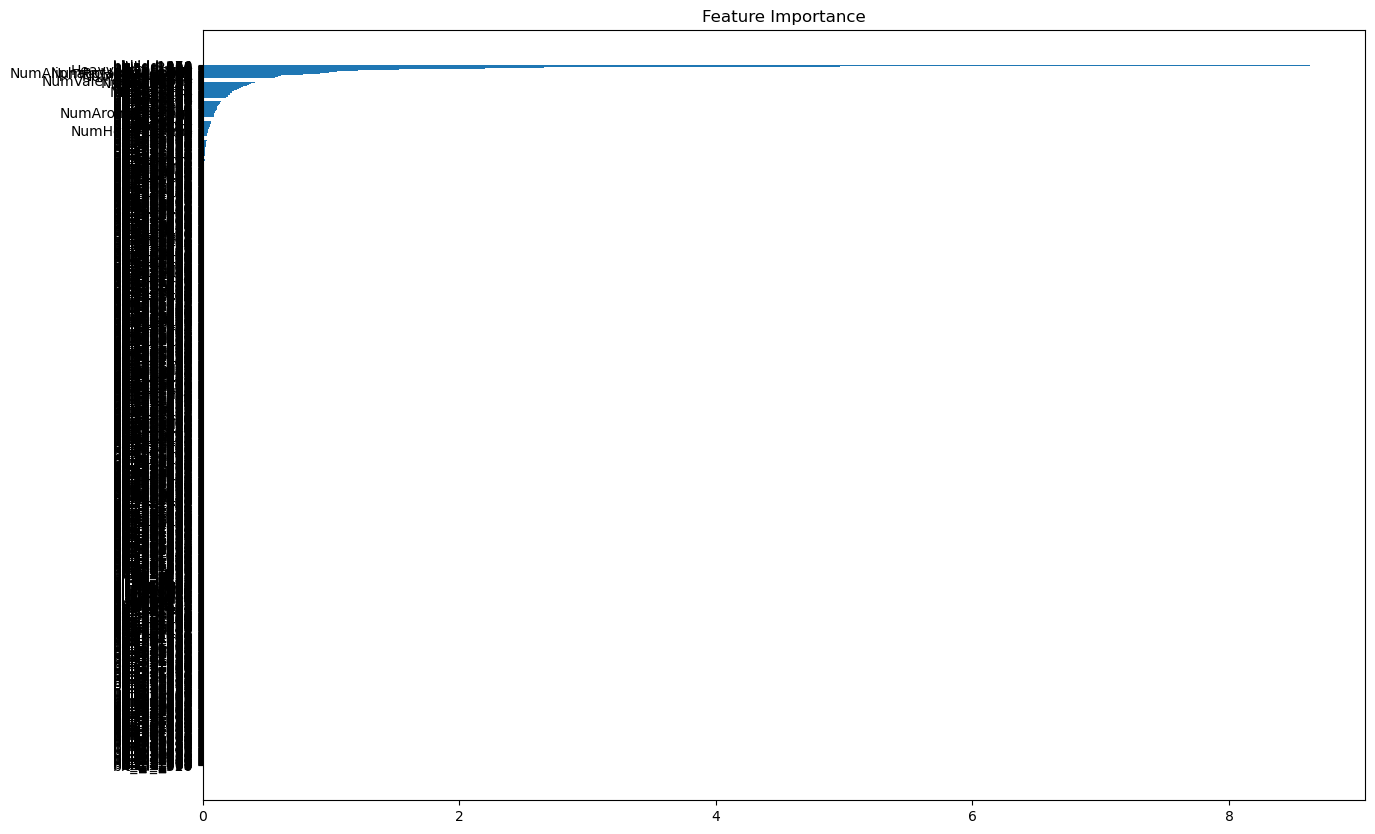

In [119]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [120]:
f_i = pd.DataFrame({'feature_importance' : feature_importance[sorted_idx], 
                    'column': np.array(X_test.columns)[sorted_idx]})
rand = f_i[f_i['column'] == 'random']['feature_importance'].values.item()
columns_to_drop = list(f_i[f_i['feature_importance'] <= rand].column.values)

In [122]:
print(len(columns_to_drop))

1788


In [121]:
full_df = full_df.drop(columns=['random'])

## Boostings with target filtering

In [123]:
full_df = full_df[full_df['IC50'] <= np.percentile(full_df['IC50'], 99)]
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns=['IC50']), full_df['IC50'], test_size=0.2, random_state=42)

In [124]:
full_df.shape

(36013, 2066)

<Axes: xlabel='IC50', ylabel='Count'>

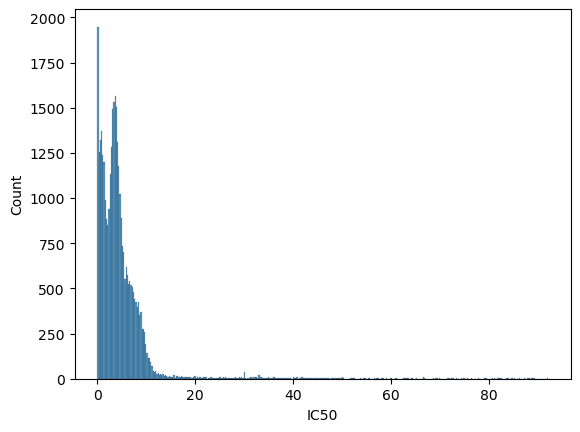

In [125]:
sns.histplot(full_df['IC50'])

In [126]:
model = CatBoostRegressor(iterations=5000,
                          eval_metric='R2',
                          loss_function='MAE',
                          verbose=False,
                          depth=2)

In [127]:
model.fit(X_train,
    y_train,
    embedding_features=['Title', 'SMILES'],
    use_best_model=True,
    eval_set=(X_test, y_test),
 )

In [128]:
y_preds = model.predict(X_test)

In [129]:
print(r2_score(y_test, y_preds))

0.1675800410587125


## Boosting with target filtering + feature importance

In [131]:
columns_to_drop.remove('random')
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns=['IC50']+columns_to_drop), full_df['IC50'], test_size=0.2, random_state=42)

In [132]:
model = CatBoostRegressor(iterations=5000,
                          eval_metric='R2',
                          loss_function='MAE',
                          verbose=False,
                          depth=2)

In [133]:
model.fit(X_train,
    y_train,
    embedding_features=['Title', 'SMILES'],
    use_best_model=True,
    eval_set=(X_test, y_test),
 )

In [134]:
y_preds = model.predict(X_test)

In [135]:
print(r2_score(y_test, y_preds))

0.23060515613061738


## Cross-validation with catboost

In [144]:
def cross_val_rf(model, data, labels, n_splits):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    scores = []
    for fold, (train_ids, test_ids) in enumerate(kfold.split(data)):
        fold_model = deepcopy(model)
        fold_model.fit( data.iloc[train_ids],
                        labels.iloc[train_ids],
                        embedding_features=['Title', 'SMILES'],
                        use_best_model=True,
                       )      

        r2_test = r2_score(labels.iloc[test_ids], fold_model.predict(data.iloc[test_ids]))
        scores.append(r2_test)
        print(f'Fold: {fold} Eval_metric: {r2_test}')
    return np.array(scores)

In [145]:
model = CatBoostRegressor(iterations=5000,
                          eval_metric='R2',
                          loss_function='MAE',
                          verbose=False,
                          depth=2)
data = full_df.drop(columns=['IC50']+columns_to_drop)
labels = full_df['IC50']
cross_val_rf(model, data, labels, 5)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold: 0 Eval_metric: -2.5524809314498036


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold: 1 Eval_metric: -2.584482006123642


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold: 2 Eval_metric: -2.875553675614615


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold: 3 Eval_metric: -2.617441132575282


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold: 4 Eval_metric: -2.001095544346014


array([-2.55248093, -2.58448201, -2.87555368, -2.61744113, -2.00109554])

## Extra Trees without embedding features

In [149]:
etr = ExtraTreesRegressor(criterion='squared_error')
etr.fit(X_train.drop(columns=['Title', 'SMILES']), y_train)

ExtraTreesRegressor()

In [153]:
y_preds = etr.predict(X_test.drop(columns=['Title', 'SMILES']))
print(r2_score(y_test, y_preds))

0.34979764294350657
